# Приоритизация гипотез и A/B-тест


СПРИНТ 8

<a name="title"></a>
### Содержание

[Описание проекта](#info)
1. [Приоритизация гипотез](#start)
2. [Анализ A/B-теста](#abtest)
  - [Предобработка](#preprocessing)
  - [Анализ кумулятивных величин выручки, среднего чека и конверсии](#cumul)  
  - [Анализ выбросов и всплесков](#data_err)  
  - [Статистическая значимость различий](#data_stat) 
3. [Общий вывод](#general)

<a name="info"></a>
# Описание проекта

**Цель:** Увеличение выручки.

**Задачи:**
1. Приоритизировать гипотезы.
2. Запустить A/B-тест и проанализировать результаты.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as stats
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
pd.set_option('display.max_colwidth', 500)

[к содержанию...](#title)

<a name="start"></a>
# Приоритизация гипотез

In [2]:
hip = pd.read_csv('datasets/hypothesis.csv')

In [3]:
hip

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
hip['ICE'] = hip['Impact']*hip['Confidence']/hip['Efforts']
hip[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


In [5]:
hip['RICE'] = hip['Reach']*hip['Impact']*hip['Confidence']/hip['Efforts']
hip[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


### Выводы:
1. Наиболее перспективные гипотезы по  **ICE: 8, 0, 7, 6 
2. Наиболее перспективные гипотезы по **RICE: 7, 2, 0, 6

При применение метода **RICE на первое место выходит гипотеза "7", т.к. ее охват пользователей  существенно выше остальных** (Reach = 10), аналогично и гипотеза "8" теряет первое место из-за обратной ситуации (Reach = 1).


[к содержанию...](#title)

<a name="abtest"></a>
# Анализ A/B-теста

<a name="preprocessing"></a>
## Предобработка

In [6]:
orders = pd.read_csv('datasets/orders.csv')
visits = pd.read_csv('datasets/visitors.csv')

### *'orders'*

In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [8]:
orders.sample(5)

,transactionId,visitorId,date,revenue,group
1111,2358087265,2115669947,2019-08-12,7500,A
539,1187625359,3362039251,2019-08-20,6382,B
75,3710046263,3290315626,2019-08-16,890,A
7,2626614568,78758296,2019-08-15,1044,A
400,2061627240,1402025725,2019-08-28,5555,A


In [9]:
orders.describe(include='all')

,transactionId,visitorId,date,revenue,group
count,1.197000e+03,1.197000e+03,1197,1.197000e+03,1197
unique,NaN,NaN,31,NaN,2
top,NaN,NaN,2019-08-05,NaN,B
freq,NaN,NaN,48,NaN,640
mean,2.155621e+09,2.165960e+09,NaN,8.348006e+03,NaN
std,1.229085e+09,1.236014e+09,NaN,3.919113e+04,NaN
min,1.062393e+06,5.114589e+06,NaN,5.000000e+01,NaN
25%,1.166776e+09,1.111826e+09,NaN,1.220000e+03,NaN
50%,2.145194e+09,2.217985e+09,NaN,2.978000e+03,NaN
75%,3.237740e+09,3.177606e+09,NaN,8.290000e+03,NaN


In [10]:
orders.duplicated().sum()

0

Пропуски и дубликаты в загруженных данных отсутствуют. Технически к полученным данным только одно замечание: **тип столбца date**, исправим его. Обработку возможных выбросов проведем на стадии анализа.

In [11]:
orders['date'] = pd.to_datetime(orders['date'])

### *'visits'*

In [12]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [13]:
visits.sample(5)

,date,group,visitors
60,2019-08-30,B,490
38,2019-08-08,B,654
11,2019-08-12,A,595
6,2019-08-07,A,644
48,2019-08-18,B,737


In [14]:
visits.describe(include='all')

,date,group,visitors
count,62,62,62.000000
unique,31,2,NaN
top,2019-08-22,A,NaN
freq,2,31,NaN
mean,NaN,NaN,607.290323
std,NaN,NaN,114.400560
min,NaN,NaN,361.000000
25%,NaN,NaN,534.000000
50%,NaN,NaN,624.500000
75%,NaN,NaN,710.500000


In [15]:
visits.duplicated().sum()

0

Пропуски и дубликаты в загруженных данных отсутствуют. Технически к полученным данным только одно замечание: **тип столбца date**, исправим его.

In [16]:
visits['date'] = pd.to_datetime(visits['date'])

***Данные загружены и проверены, переходим к их анализу.***

[к содержанию...](#title)

<a name="cumul"></a>
## Анализ кумулятивных величин выручки, среднего чека и конверсии

***Соберем агрегированные кумулятивные по дням данные:***

In [17]:
# подготовим шаблон из перечня дат и групп
dates = orders[['date', 'group']].drop_duplicates()

In [18]:
# агрегируем значения, пробежим по всем строкам и отсортируем результат
ordersAgg = dates.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'],\
                                                        orders['group'] == x['group'])]\
                 .agg({'date' : 'max', 'group' : 'max', 'transactionId' : pd.Series.nunique,\
                       'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1)\
                 .sort_values(by=['date','group']) 

In [19]:
visitsAgg = dates.apply(lambda x: visits[np.logical_and(visits['date'] <= x['date'],\
                                                                  visits['group'] == x['group'])]\
                         .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)\
                         .sort_values(by=['date','group']) 

In [20]:
# смерджим полученные ранее таблицы, окрасивим столбцы и посмотрим на результат
cumdata = ordersAgg.merge(visitsAgg, left_on=['date', 'group'], right_on=['date', 'group'])
cumdata.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumdata

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
...,...,...,...,...,...,...
57,2019-08-29,B,596,544,5559398,17708
58,2019-08-30,A,545,493,4022970,18037
59,2019-08-30,B,620,567,5774631,18198
60,2019-08-31,A,557,503,4084803,18736


### Кумулятивная выручка по группам
Подготовим данные:

In [21]:
cumRevA = cumdata[cumdata['group'] == 'A'][['date', 'revenue', 'orders']]
cumRevB = cumdata[cumdata['group'] == 'B'][['date', 'revenue', 'orders']]

Построим график

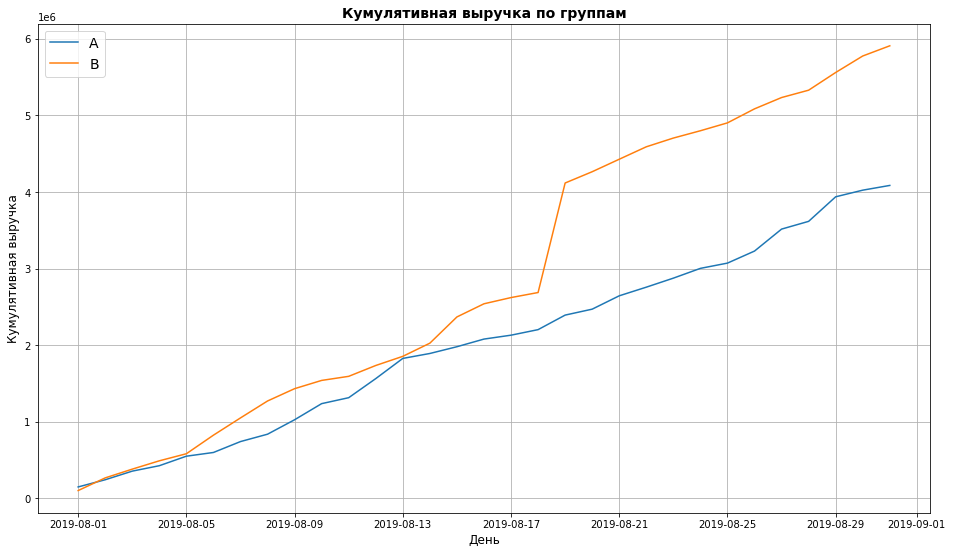

In [22]:
plt.figure(figsize=(16, 9))
plt.plot(cumRevA['date'], cumRevA['revenue'], label='A')
plt.plot(cumRevB['date'], cumRevB['revenue'], label='B')
plt.xlabel('День', fontsize=12)
plt.ylabel('Кумулятивная выручка', fontsize=12)
plt.title('Кумулятивная выручка по группам', fontsize=14, fontweight='bold')
plt.legend(fontsize=14)
plt.grid()
plt.show()

#### Вывод:
За исключением первых дней выручка группы **B** стабильно **выше** **A**.

**Выручка почти равномерно увеличивается**, существует лишь одна точка резкого роста - она может сигнализировать о всплеске числа или цены заказов. 

### Кумулятивный средний чек по группам
Построим график:

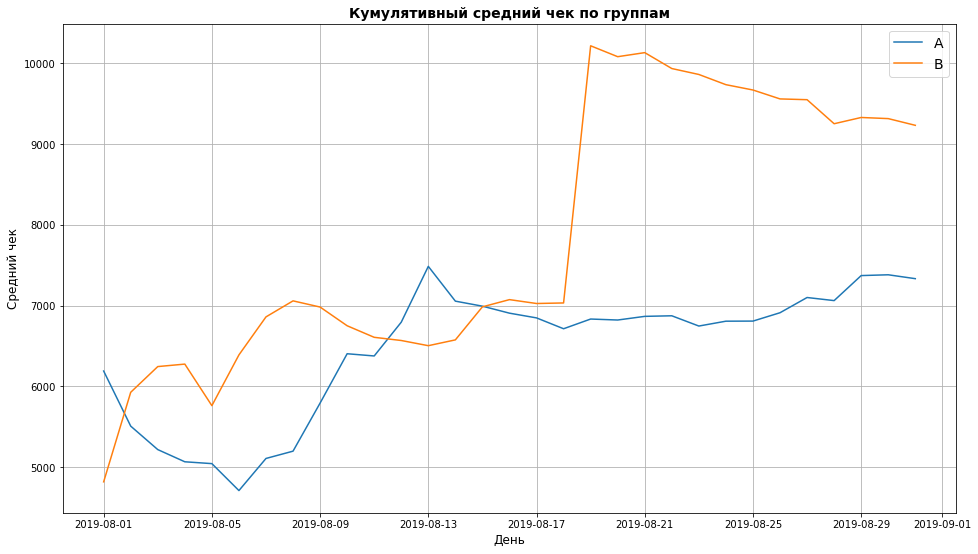

In [23]:
plt.figure(figsize=(16, 9))
plt.plot(cumRevA['date'], cumRevA['revenue']/cumRevA['orders'], label='A')
plt.plot(cumRevB['date'], cumRevB['revenue']/cumRevB['orders'], label='B')
plt.xlabel('День', fontsize=12)
plt.ylabel('Средний чек', fontsize=12)
plt.title('Кумулятивный средний чек по группам', fontsize=14, fontweight='bold')
plt.legend(fontsize=14)
plt.grid()
plt.show()

#### Вывод:
Резкий рост среднего чека группы **B** говорит о присутствии крупного заказа. Это необходимо будет учесть в ходе дальнейшего анализа. 
Группе **B** теперь понадобится больше времени чтобы прийти к реальному значению среднего чека.


### Относительное изменение кумулятивного среднего чека B к A
Подготовим данные:

In [24]:
mergeCumRev = cumRevA.merge(cumRevB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

Построим график

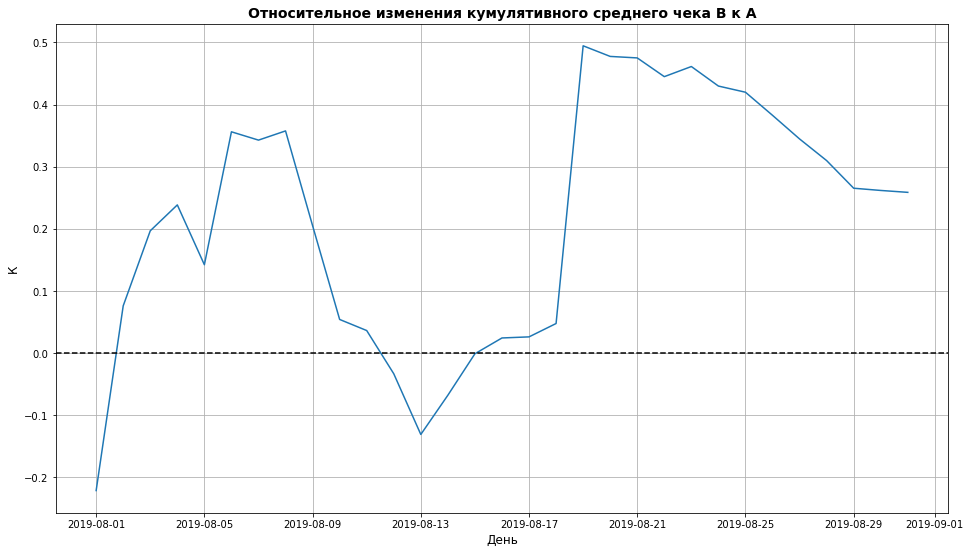

In [25]:
plt.figure(figsize=(16, 9))
plt.plot(cumRevA['date'], ((mergeCumRev['revenueB']/mergeCumRev['ordersB'])\
                           /(mergeCumRev['revenueA']/mergeCumRev['ordersA']) - 1))
plt.xlabel('День', fontsize=12)
plt.ylabel('К', fontsize=12)
plt.title('Относительное изменения кумулятивного среднего чека B к A', fontsize=14, fontweight='bold')
plt.grid()
plt.axhline(y=0, color='black', linestyle='--') 
plt.show()

#### Вывод:
**Резкие изменения графика сигнализируют о наличии выбросов** и том, что средний чек еще не пришел к установившимся значениям



### Кумулятивная конверсия по группам
Подготовим данные:

In [26]:
cumdata['conversion'] = cumdata['orders'] / cumdata['visitors']
cumdataA = cumdata[cumdata['group'] == 'A']
cumdataB = cumdata[cumdata['group'] == 'B']

In [27]:
cumdata

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.033380
1,2019-08-01,B,21,20,101217,713,0.029453
2,2019-08-02,A,44,38,242401,1338,0.032885
3,2019-08-02,B,45,43,266748,1294,0.034776
4,2019-08-03,A,68,62,354874,1845,0.036856
...,...,...,...,...,...,...,...
57,2019-08-29,B,596,544,5559398,17708,0.033657
58,2019-08-30,A,545,493,4022970,18037,0.030216
59,2019-08-30,B,620,567,5774631,18198,0.034070
60,2019-08-31,A,557,503,4084803,18736,0.029729


Построим график

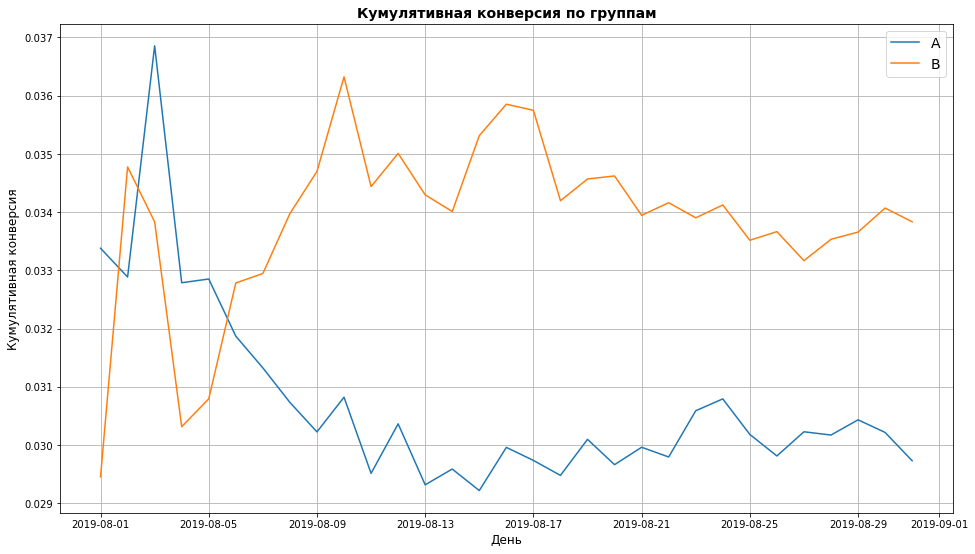

In [28]:
plt.figure(figsize=(16, 9))
plt.plot(cumdataA['date'], cumdataA['conversion'], label='A')
plt.plot(cumdataB['date'], cumdataB['conversion'], label='B')
plt.xlabel('День', fontsize=12)
plt.ylabel('Кумулятивная конверсия', fontsize=12)
plt.title('Кумулятивная конверсия по группам', fontsize=14, fontweight='bold')
plt.grid()
plt.legend(fontsize=14)
plt.show()

#### Вывод:
Значение конверсий еще **не стабилизировались**, но можно однозначно сказать, что конверсия группы **В** стремится к **более высокому посравнению** с **А** значению.

### Относительное изменение кумулятивной конверсии B к A
Подготовим данные:

In [29]:
mergeCumConversion = cumdataA[['date','conversion']].merge(cumdataB[['date','conversion']],\
                            left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

Построим график

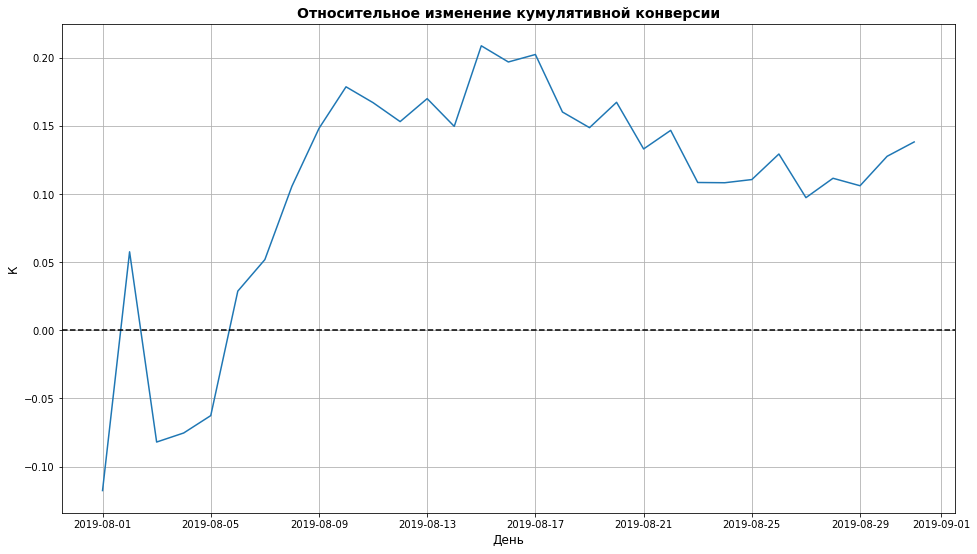

In [30]:
plt.figure(figsize=(16, 9))
plt.plot(mergeCumConversion['date'], (mergeCumConversion['conversionB']/mergeCumConversion['conversionA']-1))
plt.xlabel('День', fontsize=12)
plt.ylabel('К', fontsize=12)
plt.title('Относительное изменение кумулятивной конверсии', fontsize=14, fontweight='bold')
plt.grid()
plt.axhline(y=0, color='black', linestyle='--') 
plt.show()

#### Вывод:
В целом отношение конверсий еще не установилось, но конверсия группы **В выше конверсии А**

[к содержанию...](#title)

<a name="data_err"></a>
## Анализ выбросов и всплесков

### Количество заказов
Проанализируем количество заказов на одного пользователя на предмет аномалий. Для этого:

**построим точечный график:**

In [31]:
ordersByUsers = orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})

ordersByUsers.columns = ['userId','orders']
x_values = pd.Series(range(0,len(ordersByUsers)))

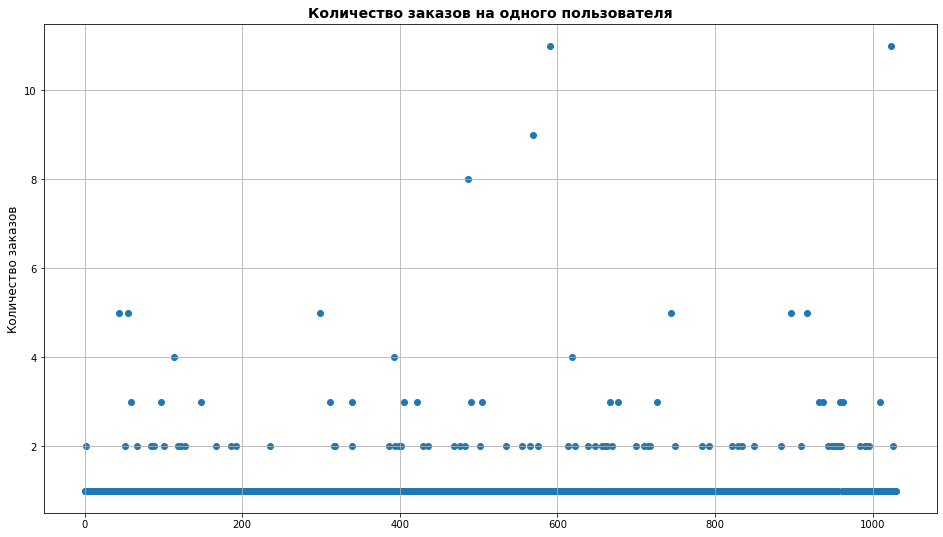

In [32]:
plt.figure(figsize=(16, 9))
plt.scatter(x_values, ordersByUsers['orders'])
plt.xlabel('', fontsize=12)
plt.ylabel('Количество заказов', fontsize=12)
plt.title('Количество заказов на одного пользователя', fontsize=14, fontweight='bold')
plt.grid()
plt.show()

**и расчитаем процентили:**

In [33]:
np.percentile(ordersByUsers['orders'], [90, 95, 99])

array([1., 2., 4.])

#### Вывод:
Не более 5% процентов пользователей оформляли больше чем 2 заказа и 10% пользователей оформляли больше 1.

**Число заказов более 2 будем считать аномалией**

### Стоимость заказов
Проанализируем стоимость одного заказа на предмет аномалий. Для этого:

**построим точечный график:**

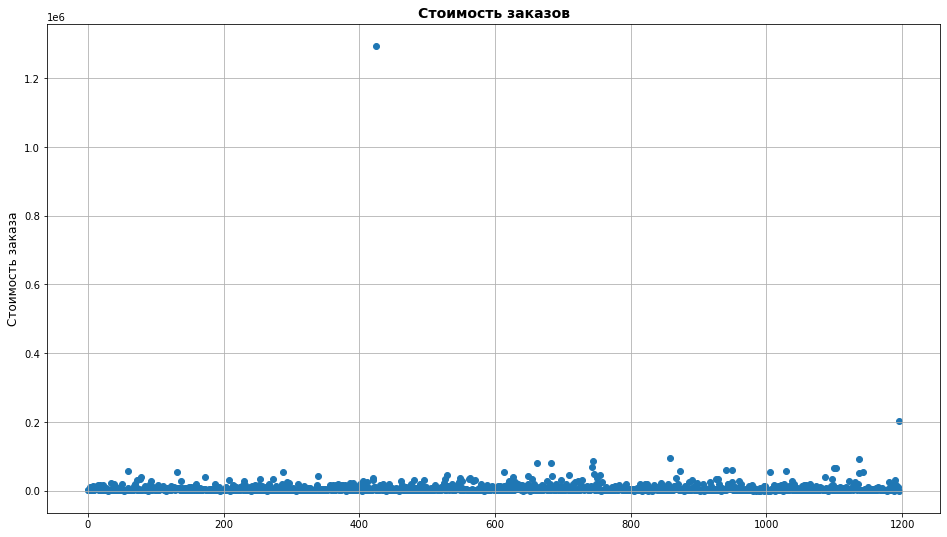

In [34]:
xx_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(16, 9))
plt.scatter(xx_values, orders['revenue'])
plt.xlabel('', fontsize=12)
plt.ylabel('Стоимость заказа', fontsize=12)
plt.title('Стоимость заказов', fontsize=14, fontweight='bold')
plt.grid()
plt.show()

**для большей детализации отсечем заказы выше 100 тысяч**

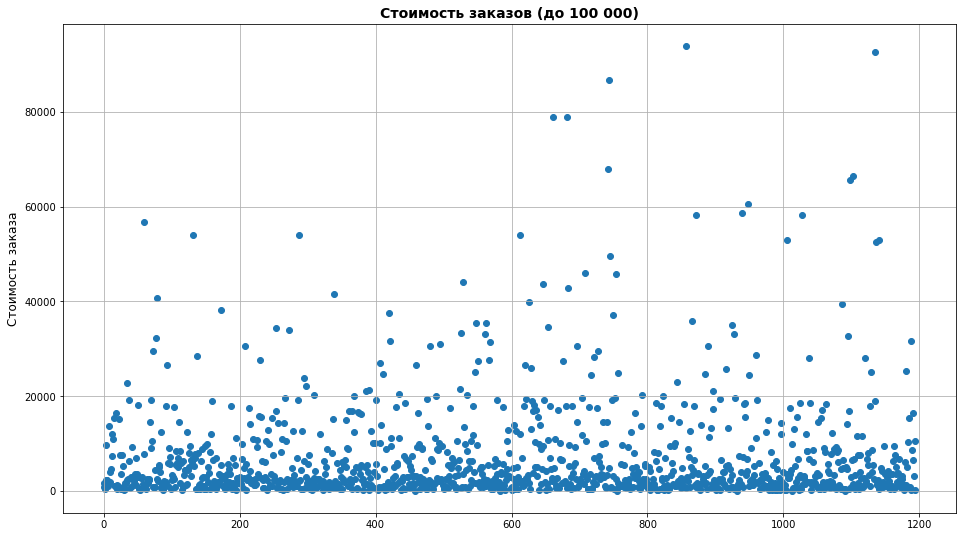

In [35]:
xx_values = pd.Series(range(0, len(orders.query('revenue < 100000')['revenue'])))
plt.figure(figsize=(16, 9))
plt.scatter(xx_values, orders.query('revenue < 100000')['revenue'])
plt.xlabel('', fontsize=12)
plt.ylabel('Стоимость заказа', fontsize=12)
plt.title('Стоимость заказов (до 100 000)', fontsize=14, fontweight='bold')
plt.grid()
plt.show()

**и расчитаем процентили:**

In [36]:
np.percentile(orders['revenue'], [90, 95, 99])

array([18168. , 28000. , 58233.2])

#### Вывод:
Не более 5% заказов привышали по сумме 28тысяч и 10% были больше 18.

**Рассматривая графики и расчитаные процентили - отсеим заказы стоимостью выше 40000**

### Вывод

**Для получения "очищенных" данных отсеим заказы стоимостью выше 40000 и число которых более 2 на одного пользователя.**

[к содержанию...](#title)

<a name="data_stat"></a>
## Статистическая значимость различий

Для проведения статистического анализа, здесь и далее, сформулируем нулевую и альтернативную гипотезы:

**Н0:** *Тестируемые выборки не имеют статистически значимого различия.*

**Н1:** *Выборки имеют статистически значимое различие.*

Установим критический уровень статистической значимости **alpha = 0.05**

### "Сырые данные"

Подготовим данные и проведем расчеты для конверсии и среднего чека:

In [37]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False)\
                                             .agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False)\
                                             .agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders'] 

Подготовитм выборки к проверке критерием Манна-Уитни:

In [38]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(
    visits[visits['group']=='A']['visitors'].sum()  - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(
    visits[visits['group']=='B']['visitors'].sum()  - len(ordersByUsersB['orders'])), name='orders')],axis=0) 

#### Статистическую значимость различия в конверсии между группами

И так проверка КОНВЕРСИИ критерием Манна-Уитни, 

**p-value:**

In [39]:
"{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided' )[1])

'0.017'

#### Относительный прирост конверсии группы В:

In [40]:
"{0:.1%}".format(sampleB.mean()/sampleA.mean()-1)

'13.8%'

### Вывод: 
Первое число — **p-value = 0.017 меньше 0.05**. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем - **Выборки имеют статически значимое различие.** 

**Плюс относительный выигрыш группы B равен 13.8%.**

#### Статистическая значимость различия в Среднем чеке между группами

И так проверка Среднего чека критерием Манна-Уитни, 

**p-value:**

In [41]:
"{0:.3f}".format(stats.mannwhitneyu(
    orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'], alternative = 'two-sided' )[1])

'0.729'

#### Относительный прирост среднего чека группы В:

In [42]:
"{0:.1%}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)

'25.9%'

### Вывод: 
**P-value = 0.729 ,больше 0.05**. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, не отвергаем! 

**Однако относительный выигрыш группы B равен 25.9%.**

Оценим картину на "очищенных" данных.

### "Очищенные данные"

Созданим список Id аномальных пользователей

In [43]:
usersWithManyOrders = pd.concat(
    [ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'], \
     ordersByUsersB[ordersByUsersB['orders'] > 2]['userId']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 40000]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0)\
                  .drop_duplicates().sort_values()
abnormalUsers.shape[0] / orders['visitorId'].nunique()

0.04364694471387003

Подготовим выборки исключая аномальных пользователей:

In [44]:
sampleAFilter = pd.concat(
    [ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],\
     pd.Series(0, index=np.arange(visits[visits['group']=='A']['visitors'].sum() - len(ordersByUsersA['orders'])),\
               name='orders')],axis=0)

sampleBFilter = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId']\
                            .isin(abnormalUsers))]['orders'],pd.Series(0, \
                            index=np.arange(visits[visits['group']=='A']['visitors'].sum()\
                                            - len(ordersByUsersB['orders'])),name='orders')],axis=0) 

#### Статистическая значимость различия в конверсии между группами

И так проверка КОНВЕРСИИ критерием Манна-Уитни, 

**p-value:**

In [45]:
"{0:.3f}".format(stats.mannwhitneyu(sampleAFilter, sampleBFilter, alternative = 'two-sided')[1])

'0.004'

#### Относительный прирост конверсии группы В:

In [46]:
"{0:.1%}".format(sampleBFilter.mean()/sampleAFilter.mean()-1)

'19.9%'

# Вывод: 
На очищенных данных результаты по конверсии улучшились. 

**Прирост в конверсии групп B увеличился до 19.9%** (было 13.8%).

#### Статистическая значимость различия в Среднем чеке между группами

И так проверка Среднего чека критерием Манна-Уитни, 

**p-value:**

In [47]:
"{0:.3f}".format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'], alternative = 'two-sided' )[1])


'0.944'

#### Относительный прирост среднего чека группы В:

In [48]:
"{0:.1%}".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorId']\
        .isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1) 

'5.8%'

### Вывод: 
**На очищенных данных картина сильно не изменилась:**

Отвергнуть нулевыю гипотезу о равенстве выборок нельзя

Oтносительный выигрыш группы B упал до  5.8%.


[к содержанию...](#title)

<a name="general"></a>
# Общий вывод

Проведенный тест показал: 
1. **Статистически значимое различие в конверсии выборок A и B.** 
2. **Конверсия группы B увеличился на 19.9%** по очищенным данным и на 13.8% по сырым.

3. Однако **не удалось подтвердить наличие статистически значимого отличия в среднем чеке** тестируемых выборок. 
4. Несмотря на это мы видим рост среднего чека группы В на 25.9% на сырых данных, относительный выигрыш группы B падает до всего 5.8% на очищенных данных. **Говорить о статистически значимом превосходстве среднего чека одной группы над другой нельзя.** 

### Тест следует остановить, зафиксировать победу группы B  по показателям конверсии и перейти к проверке следующей по приоритету гипотезе.







[к содержанию...](#title)